#Graphically Structured Diffusion Models



Notebook's author: Yasin Esfandiari

Paper: Graphically Structured Diffusion Models [[link](https://https://arxiv.org/abs/2210.11633)]

Slides: Presented in the seminar [[link](https://docs.google.com/presentation/d/1j5lyHV5XE9ayyHj9vWjaL5Bw6aKu3cQZ/view)]

<img src='https://raw.githubusercontent.com/yasin-esfandiari/deepdiffusion_seminar/main/assets/paper_info.png' width=110% />

#Introduction

In this tutorial, we will take a deeper look into the **Graphically Structured Diffusion Models**. It is assumed that you are already familiar with the basic concepts of Diffusion Models. The paper tackled four different (inverse) problems as follows:

1.   Binary Continuous Matrix Factorization
2.   Sudoku
3.   Array Logical Gate classifier
4.   Sorting

For simplicity and better conveying the important notes, we will focus on the Sorting problem. Please note that for a better reading, the large classes have been divided into multiple blocks (using inheritance) so that some descriptions can be added.

<img src='https://raw.githubusercontent.com/yasin-esfandiari/deepdiffusion_seminar/main/assets/sorting_problem.png' />


(1) Sample an unsorted list $u ∈ R^n$. with each element $u_i$
sampled from a unit normal.

(2) Sample a permutation matrix $P ∈ \{0, 1\}^{n×n}$. Factors on each row and column enforce that there should be a single 1 in each.

(3) Multiply $P$ and $u$. We integrate intermediate variables $C_{ij} := P_{ij}u_j$ and sum them as $s_i := \sum_{j} ^{} C_{ij}$ to yield $s = Pu$.

(4) We use factors between each pair of elements in $s$ to enforce that it is sorted.

We measure its performance as the RMSE between the ground-truth $s$ and the observed $u$ transformed by the sampled $P$, and plot progress during training. For these check the `validation_metrics` and the video created using `plot` later.

The $u$ and $s$, as well as the intermediate variables, if exist, are continuous, while $P$ is discrete. So before feeding to the network we dequantize $P$ to be contunous. For sampling, we quantize it to make it discrete.

# Installation

##Packages
 Installing the required packages (silent mode)

In [36]:
import sys

!{sys.executable} -m pip install torch torchaudio torchvision certifi charset-normalizer click cycler docker-pycreds fonttools gitdb GitPython idna kiwisolver matplotlib numpy packaging pathtools \
Pillow promise protobuf psutil pyparsing python-dateutil PyYAML requests scipy sentry-sdk setproctitle shortuuid six smmap sudoku-solver tqdm urllib3 wandb jupyter_contrib_nbextensions --quiet

##Retrieving the checkpoints and data

In [ ]:
!git clone https://github.com/yasin-esfandiari/deepdiffusion_seminar

##Imports

In [38]:
import argparse
import traceback
import shutil
import logging
import yaml
import sys
import os
import torch
import numpy as np
import wandb

import time
import glob
import itertools

import tqdm
import torch.utils.data as data

import torchvision.utils as tvu
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from numpy.random import randint
import functools
import random
import torch as th
import os.path
import hashlib
import errno
from torch.utils.model_zoo import tqdm

import numbers
import torchvision.transforms as transforms
from torch.utils.data import Subset

import math
import torch.nn as nn
import torch.nn.functional as F

import logging
import glob

import torch.nn.functional as TF
import torch.optim as optim

Fix encodings issues in Colab

In [39]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

torch.set_printoptions(sci_mode=False)  ## Disable scientific notation

## Insert your wandb credentials

Create a project in you wandb account with the name 'GSDM'. Add the entity and the API Key below. The entity is your account name. Please follow the [Quickstart](https://wandb.ai/quickstart?utm_source=app-resource-center&utm_medium=app&utm_term=quickstart).

In [70]:
auth_token = ''
entity = ''
project = 'GSDM'

os.system(f'wandb login {auth_token}')

0

#Parameters

## Configuration

First, we define a dictionary of type configurables and we use it later to set the configurations. These involve the configurations for the Model, Training, Optimization, Diffusion, and Sampling.

In [41]:
str2bool = lambda s: 't' in s.lower()
configurable = {'model': {'resnet': str2bool,
                          'num_transformers': int,
                          'emb_dim': int,
                          'predict': str,
                          'softmax': str2bool,
                          'var_embedding': str2bool,
                          'n_heads': int,
                          'attn_dim_reduce': int,
                          'impose_sparsity': str,
                          'max_attn_matrix_size': int,
                          'ema': str2bool,},
                'training': {'n_epochs': int,
                              'batch_size': int,
                              'max_epoch_iters': int,
                              'attn_reg_iters': int,
                              'validation_freq': int,
                              "mean_latents_loss": str2bool},
                'optim': {'lr': float},
                'data': {'n_discrete_options': eval,
                          'type': int,
                          'n': int,
                          'fit_intermediate': str2bool,
                          'save_sparsity_mask': str2bool,
                          'sparsity_mask_index': int,
                          'supervise_intermediate': str2bool,
                          'dataset_length': int,
                          'num_workers': int,
                          },
                'diffusion': {'beta_schedule': str,
                              'beta_start': float,
                              'beta_end': float,
                              'num_diffusion_timesteps': int},
                'sampling': {'sampling_batch_size': int}
                }

In [42]:
config = {
  'data': {
    'dataset': "Sorting",
    'num_workers': 0,
    'dataset_length': 1000,
    'test_dataset_length': 100,
    'save_sparsity_mask': False,  # save the mask as .npz file
    'fit_intermediate': True,  # whether to consider extra intermediate variables
    'sparsity_mask_index': 2, # connection in the graphical model
  },
  'model': {
      'emb_dim': 64,
      'num_transformers': 6,
      'var_type': 'fixedlarge',
      'ema_rate': 0.5,
      'ema': True,
      'predict': 'x0',            # predict x0 or eps
      'softmax': True,
      'var_embedding': True,
      'resnet': True,
      'n_heads': 1, # number of transformer heads
      'attn_dim_reduce': 1,
      'impose_sparsity': 'sparse',  ## [sparse, not]
  },
  'diffusion': {
      'beta_schedule': 'linear',
      'beta_start': 0.0001,
      'beta_end': 0.005,
      'num_diffusion_timesteps': 1000,  # this is for training
  },
  'training': {
      'batch_size': 10,
      'n_epochs': 150,
      'max_epoch_iters': 1000,
      'snapshot_freq': 20000,
      'mean_latents_loss': False,
  },
  'sampling': {
      'sampling_batch_size': 4,
  },
  'optim': {
      'weight_decay': 0.000,
      'optimizer': "Adam",
      'lr': 0.0002,
      'beta1': 0.9,
      'amsgrad': False,
      'eps': 0.00000001,
      'grad_clip': 1.0,

  }
}

##Arguments

Here we set the arguments. For training for the beginning, Set the 'eval_path' as None, and for loading the checkpoints, set the value to the checkpoint's path.

In [43]:
args = {
  'exp': 'sorting_experiments',                                       # Path for saving running related data.
  'verbose': 'critical',                                              # Verbose level: info | debug | warning | critical
  # 'eval_path': None,                                                # If None, do training.
  # 'eval_path': 'sorting_experiments/logs/gsdm_code/ckpt.pth',       # If specified, evaluate this ckpt instead of training. (use after re-train)
  'eval_path': 'deepdiffusion_seminar/checkpoints/ckpt.pth',          # If specified, evaluate this ckpt instead of training. (use from the git repo)
  'wandb_tags': '',                                                   # Tags for wandb
  'resume_id': 'gsdm_code',                                           # your job name
  'sample_type': 'ddpm',                                              # sampling approach (ddpm)
  'skip_type': 'uniform',                                             # skip according to (uniform or quadratic)
  'timesteps': 1000,                                                  # number of steps involved in sampling
  'weight_loss': True,                                                # Apply weights to the MSE loss so that it is equivalent to the ELBO
  'log_freq': 10000,                                                  # How often to log training progress

  'n_epochs': 60,                                                     # GSDM w/ IE
  'n': 10,                                                            # size of the unsorted vector u in our sorting problem
  'batch_size': 16,
  'sampling_batch_size': 16,
  'max_epoch_iters': 1000,
  'seed': 0                                                           # for reproducibility
}

Let us set the device to cuda if a GPU is available, otherwise to CPU.

In [44]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
logging.info("Using device: {}".format(device))
config['device'] = device

Let us set the configuration as a namespace. We set the values based on the args dictionary that we defined previously. In the namespace, we can access the local elements using dot notation. You can see the config as both dictionary and namespace in the output.

In [45]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace



print(f"config as dictionary: {config}")
for arg_type, type_configurable in configurable.items():
    for arg in type_configurable:
        try:
            config[arg_type][arg] = args[arg]
        except:
            continue

config = dict2namespace(config)
print(f"config as namespace: {config}")

config as dictionary: {'data': {'dataset': 'Sorting', 'num_workers': 0, 'dataset_length': 1000, 'test_dataset_length': 100, 'save_sparsity_mask': False, 'fit_intermediate': True, 'sparsity_mask_index': 2}, 'model': {'emb_dim': 64, 'num_transformers': 6, 'var_type': 'fixedlarge', 'ema_rate': 0.5, 'ema': True, 'predict': 'x0', 'softmax': True, 'var_embedding': True, 'resnet': True, 'n_heads': 1, 'attn_dim_reduce': 1, 'impose_sparsity': 'sparse'}, 'diffusion': {'beta_schedule': 'linear', 'beta_start': 0.0001, 'beta_end': 0.005, 'num_diffusion_timesteps': 1000}, 'training': {'batch_size': 10, 'n_epochs': 150, 'max_epoch_iters': 1000, 'snapshot_freq': 20000, 'mean_latents_loss': False}, 'sampling': {'sampling_batch_size': 4}, 'optim': {'weight_decay': 0.0, 'optimizer': 'Adam', 'lr': 0.0002, 'beta1': 0.9, 'amsgrad': False, 'eps': 1e-08, 'grad_clip': 1.0}, 'device': device(type='cuda')}
config as namespace: Namespace(data=Namespace(dataset='Sorting', num_workers=0, dataset_length=1000, test_d

In [46]:
args = dict2namespace(args)
print(args)

Namespace(exp='sorting_experiments', verbose='critical', eval_path='deepdiffusion_seminar/checkpoints/ckpt.pth', wandb_tags='', resume_id='gsdm_codessz2', sample_type='ddpm', skip_type='uniform', timesteps=1000, weight_loss=True, log_freq=10000, n_epochs=60, n=10, batch_size=16, sampling_batch_size=16, max_epoch_iters=1000, seed=0)


Set a seed for reproducibility

In [47]:
# set random seed
torch.manual_seed(args.seed)
np.random.seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(args.seed)

torch.backends.cudnn.benchmark = True

## Initialize WandB

In [ ]:
# initialise wandb ----------------------------------
unpacked_config = {}
for k, v in config.__dict__.items():
    if isinstance(v, argparse.Namespace):
        inner_dict = {k+'.'+k2: v2 for k2, v2 in v.__dict__.items()}
        unpacked_config = {**unpacked_config, **inner_dict}
    else:
        unpacked_config[k] = v

unpacked_args = {}
for k, v in args.__dict__.items():
    if isinstance(v, argparse.Namespace):
        inner_dict = {k+'.'+k2: v2 for k2, v2 in v.__dict__.items()}
        unpacked_args = {**unpacked_args, **inner_dict}
    else:
        unpacked_args[k] = v


wandb.init(entity=entity, project=project,
            config={**unpacked_config, **unpacked_args}, id=args.resume_id, tags=args.wandb_tags)

#Dataset

##Sorting Dataset

###Graphical dataset
Let's create a generic graphical dataset. This includes fit_intermediate (whether we want to use intermediate variables). Let's impose the following structure on our dataset:


*   $u$ is an unsorted vector of $n$ continuous elements
*   $s$ is the sorted version of vector $u$
*   $P$ is a $nxn$ binary matrix with only one element of 1 in each row/column
*   $C$ is a $nxn$ continuous matrix to store the intermediate variables ($K$ in the code). For example, $C_{ij} := P_{ij}u_j$.

The image below is from the main paper when the size of vector 𝑢 is 5. This will be our attention mask. To get this structure, we use `sorting_faithful_inversion_edges` function.


<img src='https://raw.githubusercontent.com/yasin-esfandiari/deepdiffusion_seminar/main/assets/attn_mask.png' width=60% />

In [49]:
class GraphicalDataset(Dataset):
    """
    A dataset combined with a graphical model.
    """
    def __init__(self, config, is_test):
        super(Dataset, self).__init__()
        self.config = config
        self.length = config.data.test_dataset_length if is_test else config.data.dataset_length
        self.is_test = is_test
        self.fit_intermediate = self.config.data.fit_intermediate

    def avg_log_prob(self, N=None):
        return torch.tensor(0.0)

    def __len__(self):
        return self.length

    def plot(self, samples_cont, samples_disc, obs_mask, **kwargs):
        return None, None # fig, ax


In [50]:
@functools.lru_cache(maxsize=1000, typed=False)
def sorting_faithful_inversion_edges(n, nc, fit_intermediate, sparsity_mask_index):
    """
    sparsity_mask_index:
        - 0 for connecting to above and below
        - 1 for connecting to everything
        - 2 for connecting to nothing
        - 3 for random
        - 4 for not symmetrizing
    """

    ## for the attention matrix, we need to find the correct indices to have [u, s, C/K, P] format...
    s = lambda i: i + n
    u = lambda i: i
    P = lambda i, j: nc + i*n + j
    K = lambda i, j: 2*n + i*n + j

    ## random connection and return
    if sparsity_mask_index == 3:
        n_rows = 2*n + (1 + fit_intermediate) * n**2
        edges = []
        for r in range(n_rows):
            edges.extend([(r, c) for c in np.random.choice(n_rows, n//2, replace=False)])
        # symmetrize
        edges += [(a, b) for (b, a) in edges]
        return  set(edges)

    edges = []
    # connect all sorted elements
    condition = {
        0: (lambda i, j: (i == j + 1 or i == j - 1 or i == j)),
        1: (lambda i, j: True),
        2: (lambda i, j: (i == j)),
        4: (lambda i, j: (i == j + 1 or i == j - 1 or i == j))
    }[sparsity_mask_index]

    edges += [(s(i), s(j))
              for i in range(n)
              for j in range(n)
              if condition(i, j)]
    # connect all unsorted elements to themselves
    edges += [(u(i), u(i))
              for i in range(n)]
    # connect all rows/columns in P
    edges += [(P(i, j), P(i, k)) for i in range(n) for j in range(n) for k in range(n)]
    edges += [(P(i, j), P(k, j)) for i in range(n) for j in range(n) for k in range(n)]

    if fit_intermediate:
        # connect each element of u to column of K
        edges += [(u(i), K(j, i)) for i in range(n) for j in range(n)]
        # and each element of s to column of K
        edges += [(K(i, j), s(i)) for i in range(n) for j in range(n)]
        # connect each element in K to the respective element in P
        edges += [(P(i, j), K(i, j)) for i in range(n) for j in range(n)]
    else:
        # and each element of s to column of P
        edges += [(P(i, j), s(i)) for i in range(n) for j in range(n)]
        # and connect all of u to all of s
        edges += [(u(i), s(j)) for i in range(n) for j in range(n)]

    # symmetrize
    if sparsity_mask_index == 4:  # not adding the symeyric
        edges = [(a, b) for (b, a) in edges]
    else:
        edges += [(a, b) for (b, a) in edges]
    return  set(edges)


Here we define our Sorting class inherited form the Graphical Dataset:


In [51]:
class Sorting(GraphicalDataset):

    def __init__(self, config, is_test):
        super().__init__(config, is_test)
        self.n = self.config.data.n
        self.fit_intermediate = self.config.data.fit_intermediate

    @property
    def n_cont(self): ## continuous variables u, s --> s is the same size as u (it is sorted)
        n = self.n    ## 10
        return n*2 + (n**2 if self.fit_intermediate else 0)   ## 20 + [100 bc intermediate C/K has n^2 elements]

    @property
    def shared_var_embeds(self):
        n = self.n
        return [n+0]*n + list(range(n)) + ([n+1]*(n**2) if self.fit_intermediate else []) + [n+2 if self.fit_intermediate else n+1]*(n**2)


    def __getitem__(self, index):
          return self.__unseeded_getitem__(index)

    def __unseeded_getitem__(self, index):
        n = self.n                  ## [10]
        u = torch.randn(n)          ## [10]
        u_sort = torch.sort(u)
        P = torch.zeros(n, n)
        K = torch.zeros(n, n) if self.fit_intermediate else torch.tensor([])
        for (i, j) in enumerate(u_sort.indices):
            P[i, j] = 1
            if self.fit_intermediate:
                K[i, j] = u[j]

        cont = torch.cat([u, u_sort.values, K.flatten()], dim=0)    ## continuous variables
        disc = P.flatten().long()                                   ## discrete variables

        return cont, disc, (self.n_cont, self.n_discrete_options, self.shared_var_embeds), (self.n, )  ## for disc, cont refer to 3.5

    @property
    def n_discrete_options(self): ## P is the discrete one: n^2 options
        n = self.n
        return [2]*(n**2)

    def faithful_inversion_edges(self):
        return sorting_faithful_inversion_edges(n=int(self.n), nc=int(self.n_cont), fit_intermediate=bool(self.fit_intermediate),
                                                sparsity_mask_index=self.config.data.sparsity_mask_index)


    def sample_obs_mask(self, B, device):
        """
        set the embedding to 1 only for the unsorted vector, because it is observed and we do not want to generate values for it
        """
        n = self.n                                                                                     ## 10

        cont_dim = self.n_cont                                                                         ## 20
        emb = torch.zeros((B, cont_dim+n**2, 1), device=device)                                        ## [B, 120, 1]
        emb[:, :n] = 1. # unsorted part: u section
        xt = torch.cat([emb[:, :cont_dim, 0], emb[:, cont_dim:, 0], emb[:, cont_dim:, 0]], dim=1)      ## [B, 220] --> cont, cont, disc
        return {"emb": emb, "xt": xt}

##Extra functions for the dataset

The following two functions will be used during validation later.

In `validation_metrics` function we have the discrete samples matrix $P$. The continuous samples vector contains the rest of the variables and we recover the unsorted vector $u$ from it. We find the ground-truth sorted version of vector $u$ and log the following values:

1.   *sort_matches*: average number of matching indices in [0, 1]
2.   *sort_completed*: total number of matching indices
3.   *rmse*: Root-mean-square deviation between the approximated sorted and ground-truth sorted vector


In the `plot` , we plot three subplots as follows:

1.   Ground-truth sorted vector
2.   Approximated sorted vector (by multiplying $P$ with $u$)
3.   Mis-matches between the two previous vectors


You can see an example of the plot below that happens during training.




In [52]:
class Sorting(Sorting):
    def validation_metrics(self, samples_disc, samples_cont, **kwargs):
        """
        used during sampling method.
        """
        B, n2 = samples_cont.shape
        n = self.n
        nc = self.n_cont
        u = samples_cont[:, :n]
        ground = torch.sort(u)
        P = samples_disc.reshape(B, n, n)
        approx = torch.argmax(P, dim=2)
        sort_matches = (ground.indices == approx).sum()/(self.n*B)
        ddpm_sort = torch.gather(u, 1, approx)
        return {'sort_matches': sort_matches,
           'sort_completed': (ground.indices == approx).all().item(),
           'rmse': ((ground.values - ddpm_sort)**2).mean().sqrt()}      ## use the sampled P to find ddpm_sort

    def plot(self, samples_cont, samples_disc, obs_mask):
        B = len(samples_cont)
        n = self.n
        fig, axes = plt.subplots(nrows=3, ncols=1)
        x_cont = samples_cont[0]
        x_disc = samples_disc[0]
        u_sort = torch.sort(x_cont[:n])
        axes[0].set_title("Sorted (ground truth)")
        axes[0].imshow(u_sort.values.reshape(1, -1), vmin=-3.0, vmax=3.0, cmap='gray')
        P_ = x_disc.reshape(n, n).float()
        x_sort = P_ @ x_cont[:n]
        axes[1].set_title("Sorting process")
        axes[1].imshow(x_sort.reshape(1, -1), vmin=-3.0, vmax=3.0,
                       cmap='gray')
        axes[2].set_title("")
        axes[2].imshow((x_sort != u_sort.values).reshape(1, -1), vmin=0.0, vmax=5.0,
                       cmap='hot')

        for ax in np.array(axes).flatten():
            ax.xaxis.set_visible(False)
            plt.setp(ax.spines.values(), visible=False)
            ax.tick_params(left=False, labelleft=False)
            ax.patch.set_visible(False)
        return fig, axes[0]


For both training and evaluation, we need to get the data. The following `get_dataset` function returns the training and test data which have different lenghts.

In [53]:



def get_dataset(args, config):
    if config.data.dataset == 'Sorting':
        dataset = Sorting(config, is_test=False)
        test_dataset = Sorting(config, is_test=True)
    else:
        raise Exception
    return dataset, test_dataset



##Visualisation of the training process

The Code below loads a video of what happens during training. Basically, it is a stack of multiple plots together.

In [54]:
## code : https://stackoverflow.com/questions/57377185/how-play-mp4-video-in-google-colab/69990457#69990457
## video : https://plai.cs.ubc.ca/2022/11/16/graphically-structured-diffusion-models/

from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 600):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

show_video("./deepdiffusion_seminar/assets/sorting.mp4")


#Diffusion Model

##Helper functions

Here we define some helper functions. In the first one, get_timestep_embedding, we get the embeddings of timesteps. We also have an activation function and a group normalization.

In [55]:
def get_timestep_embedding(timesteps, embedding_dim, max_timesteps=10000):
    """
    This matches the implementation in Denoising Diffusion Probabilistic Models:
    From Fairseq.
    Build sinusoidal embeddings.
    This matches the implementation in tensor2tensor, but differs slightly
    from the description in Section 3.5 of "Attention Is All You Need".
    """
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(max_timesteps) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = emb.to(device=timesteps.device)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
    return emb


def nonlinearity(x):
    # swish
    return x*torch.sigmoid(x)


def Normalize(in_channels):
    return torch.nn.GroupNorm(num_groups=32, num_channels=in_channels, eps=1e-6, affine=True)

##Transformer modules

### Building blocks of our Diffusion Model
Attention Block and Resnet Block are used in our main model. We will use a number of Resnet blocks([(He et al., 2016](https://arxiv.org/abs/1512.03385)) followed by Attention blocks ([(Vaswani et al.,
2017](https://arxiv.org/abs/1706.03762)) later. An example GSDM architecture for a graphical model with one observed and three latent variables. The components within the dashed lines are repeated multiple
times. Arrows represent information flow. There are also some linear operations in the model that we do skip here.

<img src='https://raw.githubusercontent.com/yasin-esfandiari/deepdiffusion_seminar/main/assets/self_attention.png' width=70% />

In [56]:
class ResnetBlock(nn.Module):
    def __init__(self, *, in_channels, out_channels=None, conv_shortcut=False,
                 dropout, temb_channels=512, kernel_size=3, var_emb_channels=None):
        super().__init__()
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut

        self.norm1 = Normalize(in_channels)
        self.conv1 = torch.nn.Conv2d(in_channels,
                                     out_channels,
                                     kernel_size=kernel_size,
                                     stride=1,
                                     padding=kernel_size//2)
        self.temb_proj = torch.nn.Linear(temb_channels,
                                         out_channels)
        if var_emb_channels is not None:
            self.var_proj = torch.nn.Conv2d(var_emb_channels,
                                            out_channels,
                                            kernel_size=1)
        self.norm2 = Normalize(out_channels)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(out_channels,
                                     out_channels,
                                     kernel_size=kernel_size,
                                     stride=1,
                                     padding=kernel_size//2)
        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                self.conv_shortcut = torch.nn.Conv2d(in_channels,
                                                     out_channels,
                                                     kernel_size=kernel_size,
                                                     stride=1,
                                                     padding=kernel_size//2)
            else:
                self.nin_shortcut = torch.nn.Conv2d(in_channels,
                                                    out_channels,
                                                    kernel_size=1,
                                                    stride=1,
                                                    padding=0)

    def forward(self, x, temb, var_emb=None):
        h = x
        h = self.norm1(h)
        h = nonlinearity(h)
        h = self.conv1(h)

        h = h + self.temb_proj(nonlinearity(temb))[:, :, None, None]
        if var_emb is not None:
            h = h + self.var_proj(var_emb)

        h = self.norm2(h)
        h = nonlinearity(h)
        h = self.dropout(h) ## [10, 64, 840, 1]
        h = self.conv2(h)

        if self.in_channels != self.out_channels:
            if self.use_conv_shortcut:
                x = self.conv_shortcut(x)
            else:
                x = self.nin_shortcut(x)

        return x+h


class AttnBlock(nn.Module):
    def __init__(self, in_channels, n_heads=1, attn_dim_reduce=1):
        super().__init__()
        self.in_channels = in_channels
        self.n_heads = n_heads

        self.norm = Normalize(in_channels)

        self.q = torch.nn.Conv2d(in_channels,
                                 in_channels//attn_dim_reduce,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.k = torch.nn.Conv2d(in_channels,
                                 in_channels//attn_dim_reduce,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.v = torch.nn.Conv2d(in_channels,
                                 in_channels//attn_dim_reduce,
                                 kernel_size=1,
                                 stride=1,
                                 padding=0)
        self.proj_out = torch.nn.Conv2d(in_channels//attn_dim_reduce,
                                        in_channels,
                                        kernel_size=1,
                                        stride=1,
                                        padding=0)

    def sparse_forward(self, x, sparse_attention_mask_and_indices):
        h_ = x    # [B, 64, 120, 1]
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        b, c, h, w = q.shape
        heads = self.n_heads
        reshape_for_transformer = lambda t: t.reshape(b, heads, c//heads, h*w)
        # beta = (int(c//heads)**(-0.5)) # standard attention scaling
        # we used unnormalized attention, it should not matter
        beta = 1
        q = reshape_for_transformer(q)  # [B, 64, 120, 1] --> [B, 1, 64, 120]
        k = reshape_for_transformer(k)
        v = reshape_for_transformer(v)


        valid_indices_mask, attendable_indices = sparse_attention_mask_and_indices
        nq, max_attendable_keys = valid_indices_mask.shape    ## 120, 23
        attendable_indices = attendable_indices.view(1, 1, nq, max_attendable_keys)\
                                               .expand(b, heads, nq, max_attendable_keys) # [B, 1, 120, 23]
        def get_keys_or_values(t, indices):
            *batch_shape, nd, nv = t.shape
            t = t.transpose(-1, -2)\
                .view(*batch_shape, nv, 1, nd)\
                .expand(*batch_shape, nv, max_attendable_keys, nd)
            index = indices.view(*batch_shape, nv, max_attendable_keys, 1)\
                .expand(-1, -1, -1, -1, c//heads)
            return t.gather(dim=2, index=index)

        attended_keys = get_keys_or_values(k, indices=attendable_indices)   # b x heads x h*w x max_attendable_keys x c, [B, 1, 120, 23, 64]
        attended_values = get_keys_or_values(v, indices=attendable_indices)

        weights = beta * torch.einsum('bhqkc,bhcq->bhqk', attended_keys, q) # KQ
        inf_matrix = torch.zeros_like(valid_indices_mask)
        inf_matrix[valid_indices_mask==0] = torch.inf                       # maskings the attention
        weights = weights - inf_matrix.view(1, 1, nq, max_attendable_keys)  # [B, 1, 120, 23]
        weights = weights.softmax(dim=-1)

        h_ = torch.einsum('bhqk,bhqkc->bhqc', weights, attended_values)     # now multiplpy with v
        h_ = h_.permute(0, 3, 1, 2).reshape(b, c, h, w)
        h_ = self.proj_out(h_)
        out = x+h_
        return out, None

    def forward(self, x, sparsity_matrix=None, sparse_attention_mask_and_indices=None, return_w=False):

        if sparse_attention_mask_and_indices is not None:
            out, w_ = self.sparse_forward(x, sparse_attention_mask_and_indices)
            return out, w_ if return_w else out

        h_ = x
        h_ = self.norm(h_)
        q = self.q(h_)
        k = self.k(h_)
        v = self.v(h_)

        b, c, h, w = q.shape
        heads = self.n_heads
        reshape_for_transformer = lambda t: t.reshape(b, heads, c//heads, h*w)
        q = reshape_for_transformer(q)
        k = reshape_for_transformer(k)
        v = reshape_for_transformer(v)

        w_ = torch.einsum('bhdk,bhdq->bhqk', k, q)
        w_ = w_ * (int(c//heads)**(-0.5))
        if sparsity_matrix is not None:
            inf_matrix = torch.zeros_like(sparsity_matrix)
            inf_matrix[sparsity_matrix==0] = torch.inf
            w_ = w_ - inf_matrix.view(-1, 1, h*w, h*w)
        w_ = torch.nn.functional.softmax(w_, dim=3)
        h_ = torch.einsum('bhdk,bhqk->bhdq', v, w_)
        h_ = h_.view(b, c, h, w)

        h_ = self.proj_out(h_)

        out = x+h_
        return out, w_ if return_w else out

##Transformer Class

Here we define our main model that we use in the training later. One of the most important points is that we are using the idea in inpainting as follows: "The input to Our model is a linear combination of observed and unobserved regions of the noisy image (at timestep t)". In the following image, the observed variable is inside the medical mask while the unobserved variable is the region outside of the medical mask.

<img src='https://raw.githubusercontent.com/yasin-esfandiari/deepdiffusion_seminar/main/assets/inpainting.png' width=100% />

In our experiment, as we discussed in the beginning, the observed variable is the $u$ vector(unsorted) which we have the mask of 1, while $s$, $P$, and the intermediate variables are the unobserved variables in which the mask is 0. You can see a sketch of the input to the model while training.

<img src='https://raw.githubusercontent.com/yasin-esfandiari/deepdiffusion_seminar/main/assets/training.png' width=100% />

In [57]:
class TransformerModel(nn.Module):
    def __init__(self, config, dataset, faithful_inversion_edges=None, sparse_attention_mask_and_indices=None):
        super().__init__()
        self.config = config
        self.dataset = dataset
        self.n_cont = dataset.n_cont    # 20
        self.n_discrete_options = dataset.n_discrete_options    # [2,2,2,...] list of 100 elements
        self.shared_var_embeds = slice(0, self.n_variables)     # slice(0, 120, None)
        self.emb_dim = self.config.model.emb_dim    # 64
        self.temb_dim = self.emb_dim    # 64
        self.num_transformers = config.model.num_transformers   # 6

        # timestep embedding
        self.temb = nn.Module()
        self.temb.dense = nn.ModuleList([
            torch.nn.Linear(self.emb_dim,
                            self.temb_dim),
            torch.nn.Linear(self.temb_dim,
                            self.temb_dim),
        ])

        self.cont_in_proj = nn.Conv1d(1, self.emb_dim, kernel_size=1)
        self.cont_out_proj = nn.Conv1d(self.emb_dim, 1, kernel_size=1)
        disc_in_projs = {}
        disc_out_projs = {}
        for n_options in set(self.n_discrete_options):  ## run 1 time
            disc_in_projs[str(n_options)] = nn.Conv1d(n_options, self.emb_dim, kernel_size=1)   ## {'2': Conv1d(2, 64, kernel_size=(1,), stride=(1,))}
            disc_out_projs[str(n_options)] = nn.Conv1d(self.emb_dim, n_options, kernel_size=1)  ## {'2': Conv1d(64, 2, kernel_size=(1,), stride=(1,))}
        self.disc_in_projs = nn.ModuleDict(disc_in_projs) ## ModuleDict((2): Conv1d(2, 64, kernel_size=(1,), stride=(1,)))
        self.disc_out_projs = nn.ModuleDict(disc_out_projs) ## ModuleDict((2): Conv1d(64, 2, kernel_size=(1,), stride=(1,)))

        if config.model.var_embedding:
            self.var_embs = nn.Parameter(torch.randn(1, self.emb_dim,   ## [1, 64, 120, 1]
                                          self.n_variables, 1),
                              requires_grad=True)



        else:
            self.var_embs = None

        # 'fixed' conditionals
        self.cond_embs = nn.Parameter(  ## [1, 1, 64]
            torch.randn(1, 1, self.emb_dim), requires_grad=True)

        transformers = []
        for i in range(self.num_transformers):
            transformers.append(
                AttnBlock(self.emb_dim, n_heads=self.config.model.n_heads,
                          attn_dim_reduce=self.config.model.attn_dim_reduce)
            )
        self.transformers = nn.ModuleList(transformers)

        self.res_blocks = nn.Sequential(*[ResnetBlock(in_channels=self.emb_dim, out_channels=self.emb_dim,
                                                      temb_channels=self.temb_dim, dropout=False,
                                                      var_emb_channels=self.emb_dim if self.config.model.var_embedding else None,
                                                      kernel_size=1)
                                          for _ in range(self.num_transformers)])

        assert self.config.model.impose_sparsity in ['sparse', 'not']
        if self.config.model.impose_sparsity == 'not':  ## no sparsity, just skip the initialization
            pass
        elif sparse_attention_mask_and_indices is None:
            self.faithful_inversion_matrix = self.make_faithful_inversion_matrix(faithful_inversion_edges)  # [120, 120]
            if self.config.data.save_sparsity_mask:
                np.savez(f"{self.config.data.dataset}_sparsity_mask.npz",
                         mask=self.faithful_inversion_matrix)
            wandb.log({'attn/sparsity': wandb.Image(self.faithful_inversion_matrix.cpu().numpy())})
            max_attendable_keys = self.faithful_inversion_matrix.sum(dim=1).max().int().item()  # 23
            self.valid_indices_mask, self.attendable_indices = (nn.Parameter(t, requires_grad=False) for t in self.faithful_inversion_matrix.topk(k=max_attendable_keys, dim=1))  ## its better to keep the attendables (the mask is sparse)
            # [120, 23], [120, 23]
        else:
            self.valid_indices_mask, self.attendable_indices = (nn.Parameter(t, requires_grad=False) for t in sparse_attention_mask_and_indices)

    @property
    def n_variables(self):
        return self.n_cont + len(self.n_discrete_options)

    @property
    def x_dim(self):
        return self.n_cont + sum(self.n_discrete_options)

    def variable_emb_begin(self, var_index):
        if var_index < self.n_cont:
            return var_index
        else:
            return self.n_cont+sum(self.n_discrete_options[:var_index-self.n_cont])

    def variable_emb_dim(self, var_index):
        if var_index < self.n_cont:
            return 1
        else:
            return self.n_discrete_options[var_index-self.n_cont]

    ## these two are related
    def project_x_to_emb(self, x, cont_in_proj, disc_in_projs):
        B, _ = x.shape
        NC = self.n_cont
        if NC > 0:
            cont = x[:, :NC].view(B, 1, NC)
            cont_emb = cont_in_proj(cont)    # B x emb_dim x NC
            embs = [cont_emb]
        else:
            embs = []
        index = NC
        for n_options in set(self.n_discrete_options):
            n_var = sum(el == n_options for el in self.n_discrete_options)
            index_step = n_var*n_options
            values = x[:, index:index+index_step].view(B, n_var, n_options).permute(0, 2, 1)
            emb = disc_in_projs[str(n_options)](values)    # B x emb_dim x n_var
            embs.append(emb)
            index += index_step
        return torch.cat(embs, dim=2).permute(0, 2, 1) # B x n_var x emb_dim

    def project_emb_to_x(self, emb):
        B, *_ = emb.shape
        NC = self.n_cont
        if NC > 0:
            cont_emb = emb[:, :NC]
            cont_x = self.cont_out_proj(cont_emb.permute(0, 2, 1)).view(B, NC)
            xs = [cont_x]
        else:
            xs = []
        index = NC
        for n_options in set(self.n_discrete_options):
            n_var = sum(el == n_options for el in self.n_discrete_options)
            emb_bit = emb[:, index:index+n_var].permute(0, 2, 1)   # B x emb_dim x n_var
            x_bit = self.disc_out_projs[str(n_options)](emb_bit)
            if self.config.model.softmax:
                x_bit = torch.softmax(x_bit, dim=1)
            x_bit = x_bit.permute(0, 2, 1)  # B x n_var x n_options
            x_bit = x_bit.reshape(B, -1)
            xs.append(x_bit)
            index += n_var
        return torch.cat(xs, dim=1)


    def forward(self, x, t, obs_mask=None, obs=None, log_attn=False):
        B, N = x.shape
        NV = self.n_variables
        D = self.emb_dim

        # timestep embedding
        temb = get_timestep_embedding(t, self.emb_dim)
        temb = self.temb.dense[0](temb)
        temb = nonlinearity(temb)
        temb = self.temb.dense[1](temb)


        if obs_mask is not None:
            ## outside of obs_mask use the noisy image of data x
            ## inside of obs_mask use the obs data (u vector)
            x = x*(1-obs_mask["xt"]) + obs*obs_mask["xt"]                  ## [B, 220]


        emb = self.project_x_to_emb(x, self.cont_in_proj, self.disc_in_projs)
        assert emb.shape == (B, NV, D)

        # 'fixed' conditionals
        emb = emb + self.cond_embs * obs_mask["emb"]


        if not self.config.model.resnet:
            emb = emb + temb.view(B, 1, D)
        for l, (res_block, transformer) in enumerate(zip(self.res_blocks, self.transformers)):
            emb = emb.permute(0, 2, 1).reshape(B, D, NV, 1)
            if self.config.model.resnet:
                var_embs = self.var_embs[:, :, self.shared_var_embeds, :] if self.var_embs is not None else None
                emb = res_block(emb, temb, var_embs)

            if self.config.model.impose_sparsity == 'not':  ## dense
                attn_sparsity_matrix = torch.ones((B, NV, NV)).to(emb.device)
                attn_sparsity_matrix = attn_sparsity_matrix * self.faithful_inversion_matrix.unsqueeze(0).to(emb.device)
                emb, w = transformer(emb, return_w=True, sparsity_matrix=attn_sparsity_matrix)
            elif self.config.model.impose_sparsity == 'sparse':
                sparsity_things = (self.valid_indices_mask, self.attendable_indices)
                emb, w = transformer(emb, return_w=True,
                                     sparse_attention_mask_and_indices=sparsity_things)
            else:
                emb, w = transformer(emb, return_w=True)
            emb = emb.view(B, D, NV).permute(0, 2, 1)   # [B, 64, 120, 1] --> [B, 120, 64]


        assert emb.shape == (B, NV, D)
        emb = self.project_emb_to_x(emb[:, :NV])    # [B, 120, 64] --> [B, 220]

        assert emb.shape == (B, N)
        if obs_mask is not None:
            # ouside mask use the embeddings
            # inside mask use the observation
            emb = emb * (1 - obs_mask["xt"]) + obs * obs_mask["xt"]

        return emb

    def make_faithful_inversion_matrix(self, edges):
        """
        create a attention mask based on the edges
        """
        NV = self.n_variables             ## 120
        matrix = torch.zeros((NV, NV))
        if edges is None:
            return matrix*0 + 1.          ## all 1
        for i, j in edges:
            matrix[i, j] = 1.             ## for edges
        for i in range(NV):
            matrix[i, i] = 1.             ## diagonal
        return matrix

##EMA

Stabilizing training with Exponential Moving Average (EMA)

This idea is found in most of the implementations, which allows to implement a form of model momentum. Instead of directly updating the weights of the model, we keep a copy of the previous values of the weights, and then update a weighted mean between the previous and new version of the weights. Here, we reuse the implementation proposed in the [DDIM repository](https://github.com/ermongroup/ddim).

In [58]:
class TransformerModel(TransformerModel):
    def reinit(self):
        sparsity_things = (self.valid_indices_mask, self.attendable_indices) if self.config.model.impose_sparsity == 'sparse' else None
        return TransformerModel(self.config, self.dataset, faithful_inversion_edges=None,
                                sparse_attention_mask_and_indices=sparsity_things)


class EMAHelper(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        if isinstance(module, nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        if isinstance(module, nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (
                    1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        if isinstance(module, nn.DataParallel):
            module = module.module
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        if isinstance(module, nn.DataParallel):
            inner_module = module.module
            module_copy = inner_module.reinit().to(inner_module.config.device)
            module_copy.load_state_dict(inner_module.state_dict())
            module_copy = nn.DataParallel(module_copy)
        else:
            module_copy = type(module)(module.config).to(module.config.device)
            module_copy.load_state_dict(module.state_dict(), strict=False)

        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict


##Optimizer setup

In [59]:
def get_optimizer(config, parameters):
    if config.optim.optimizer == 'Adam':
        return optim.Adam(parameters, lr=config.optim.lr, weight_decay=config.optim.weight_decay,
                          betas=(config.optim.beta1, 0.999), amsgrad=config.optim.amsgrad,
                          eps=config.optim.eps)
    elif config.optim.optimizer == 'RMSProp':
        return optim.RMSprop(parameters, lr=config.optim.lr, weight_decay=config.optim.weight_decay)
    elif config.optim.optimizer == 'SGD':
        return optim.SGD(parameters, lr=config.optim.lr, momentum=0.9)
    else:
        raise NotImplementedError(
            'Optimizer {} not understood.'.format(config.optim.optimizer))

##Diffusion Process

In [60]:
class DiffusionProcess():
    def __init__(self, b: torch.Tensor, T):
        """
        b: length T tensor of beta_1,...,beta_T
        """
        assert len(b) == T
        t = torch.arange(0, T+1).view(T+1).to(b.device)
        self.beta = torch.cat([torch.zeros(1).to(b.device), b], dim=0)
        self.alpha = (1 - self.beta).cumprod(dim=0).index_select(0, t).view(-1)  # this is alpha_bar in DDPM notation

        at = self.alpha[:-1]
        atp1 = self.alpha[1:]
        btp1 = self.beta[1:]

        # logvars for each x_t given x_{t+1}
        self.reverse_p_logvar = (1 - atp1/at).log()               # the DDIM paper calls this noisy DDPM, denoted with \hat{\sigma}
        self.reverse_q_logvar = (btp1 * (1-at) / (1-atp1)).log()  # from DDPM's equation 6

        # such that index t corresponds to scaling of x0 (or x_{t+1}) in q(x_t|x_{t+1},x_0)
        self.reverse_mean_x0_scaling = (at.sqrt() * btp1) / (1 - atp1)               # DDPM equation 7
        self.reverse_mean_xtp1_scaling = (1 - btp1).sqrt() * (1 - at) / (1 - atp1)   # DDPM equation 7

        # compute logvars and mean scalings such that index t corresponds to processes q(x_t|x_0)
        self.forward_q_scaling = self.alpha.sqrt()    # DPPM equation 4
        self.forward_q_logvar = (1-self.alpha).log()  # DPPM equation 4


    def get(self, name, t=None, leading_dims=0, trailing_dims=0):     ## will be used in ddpm_elbo
        attr = getattr(self, name)
        if t is not None:
            attr = attr.index_select(dim=0, index=t)
        attr = attr.view(*(1,)*leading_dims, -1, *(1,)*trailing_dims)
        return attr


    @property
    def elbo_weighting(self):
        """
        Return weights for MSE loss (on predicted epsilon) at each time t so that optimising the loss
        corresponds to optimising the ELBO.
        """
        sigma_p = (0.5*self.reverse_p_logvar).exp()
        w1 = (1 - self.alpha[1]) / (2*self.alpha[1]*sigma_p[0]**2)

        atm1 = self.alpha[1:-1]
        at = self.alpha[2:]
        bt = self.beta[2:]
        # index i of wt corresponds to loss term with x_{i+2}
        wt = (atm1*bt**2) / (2*sigma_p[1:]**2*(1-at)*at)
        return torch.cat([w1.view(1), wt])

During evaluation, we will use the `ddpm_steps` function for sampling based on, and `ddpm_elbo` for logging the elbo values.


In [61]:
## From https://github.com/plai-group/gsdm/blob/338bff5b11e915d4bbd4292338d4d0d354eb537c/functions/denoising.py w/o any modifications


@torch.jit.script
def gaussian_analytical_kl(mu1, mu2, logsigma1, logsigma2):
    return -0.5 + logsigma2 - logsigma1 + 0.5 * (logsigma1.exp() ** 2 + (mu1 - mu2) ** 2) / (logsigma2.exp() ** 2)


@torch.jit.script
def gaussian_log_prob(x, mu, logsigma):
    return -logsigma - 0.5*torch.tensor(2*np.pi).log() - 0.5 * ( (x - mu) / logsigma.exp() ) ** 2

#####


def compute_alpha(beta, t, dims_like=torch.tensor([])):
    beta = torch.cat([torch.zeros(1).to(beta.device), beta], dim=0)
    a = (1 - beta).cumprod(dim=0).index_select(0, t + 1).view(-1)
    while a.ndim < dims_like.ndim:
        a = a.unsqueeze(-1)
    return a


def ddpm_steps(x, seq, model, b, config, obs=None, obs_mask=None):
    with torch.no_grad():
        n = x.size(0)
        seq_next = [-1] + list(seq[:-1])
        xs = [x]
        x0_preds = []
        betas = b
        for i, j in zip(reversed(seq), reversed(seq_next)):
            t = (torch.ones(n) * i).to(x.device)
            next_t = (torch.ones(n) * j).to(x.device)
            at = compute_alpha(betas, t.long(), x)
            atm1 = compute_alpha(betas, next_t.long(), x)
            beta_t = 1 - at / atm1
            x = xs[-1].to(x.device)
            output = model(x, t.float(), obs_mask=obs_mask, obs=obs)

            if config.model.predict == 'eps':
                x0_pred = (1.0 / at).sqrt() * x - (1.0 / at - 1).sqrt() * output
            elif config.model.predict == 'x0':
                x0_pred = output

            x0_preds.append(x0_pred.to('cpu'))
            mean_eps = (
                (atm1.sqrt() * beta_t) * x0_pred + ((1 - beta_t).sqrt() * (1 - atm1)) * x
            ) / (1.0 - at)

            mean = mean_eps
            noise = torch.randn_like(x)
            mask = 1 - (t == 0).float()
            mask = mask.view(-1)
            while mask.ndim < x.ndim:
                mask = mask.unsqueeze(-1)
            logvar = beta_t.log()

            sample = mean + mask * torch.exp(0.5 * logvar) * noise
            xs.append(sample.to('cpu'))
    return xs, x0_preds   ## 1001, 1000


@torch.no_grad()
def ddpm_elbo(model,
              x0: torch.Tensor,
              b: torch.Tensor, T,
              n_cont, config,
              obs_mask=None):
    """
    b is a vector of beta_1 to beta_T
    Indices are shifted relative to paper. We sum the:
    - likelihood for x_{-1} given x_0
    - KLs for each x_{t-1} given x_t for t in [1, T-2] inclusive
    - KL between Gaussian and x_{T-1}
    """
    device = b.device
    process = DiffusionProcess(b, T)
    obs_mask_dict = {'xt': None, 'emb': None} if obs_mask is None else obs_mask
    def apply_mask(x, mask, slice_mask_to=None, slice_mask_from=None):
        if mask is None:
            return x
        if slice_mask_to is not None:
            mask = mask[:, :slice_mask_to]
        if slice_mask_from is not None:
            mask = mask[:, slice_mask_from:]
        return x * (1-mask.unsqueeze(1))

    B, *data_dims = x0.shape
    x0 = x0.view(B, 1, *data_dims).to(device)       ## [B, 1, 220]
    kwargs = dict(leading_dims=1, trailing_dims=len(data_dims))

    # compute various factors and sample xt -----------------------------------------------
    forward_scaling = process.get('forward_q_scaling', **kwargs)
    forward_logvar = process.get('forward_q_logvar', **kwargs)
    scaling_p1, logvar_p1 = forward_scaling[:, 1:], forward_logvar[:, 1:]   # q(x_t|x0) for t=1,...,T
    xtp1s = scaling_p1 * x0 + (0.5*logvar_p1).exp() * torch.randn(size=(B, T, *data_dims), device=device)
    tp1s = torch.arange(1, T+1).view(1, T).expand(B, T).to(device)
    output = []
    for i in range(T): # tp1, xtp1 in zip(tp1s, xtp1s):
        output.append(model(xtp1s[:, i], tp1s[:, i], obs=x0[:, 0], obs_mask=obs_mask))
    # stack again
    output = torch.stack(output, dim=1)
    assert output.shape == (B, T, *data_dims)
    if config.model.predict == 'eps':
        x0_from_tp1 = (1./scaling_p1) * (xtp1s - output*(0.5*logvar_p1).exp())
    elif config.model.predict == 'x0':
        x0_from_tp1 = output

    # means for predicted x_0,...,x_{T-1}
    reverse_mean_x0_scaling = process.get('reverse_mean_x0_scaling', **kwargs)
    reverse_mean_xtp1_scaling = process.get('reverse_mean_xtp1_scaling', **kwargs)
    p_mean = x0_from_tp1 * reverse_mean_x0_scaling + xtp1s * reverse_mean_xtp1_scaling
    q_mean = x0 * reverse_mean_x0_scaling + xtp1s * reverse_mean_xtp1_scaling
    p_logvar = process.get('reverse_p_logvar', **kwargs)
    q_logvar = process.get('reverse_q_logvar', **kwargs)

    # evaluate sum of KL losses for predicting x_1,...,x_{T-1}
    kls = gaussian_analytical_kl(mu1=q_mean[:, 1:], mu2=p_mean[:, 1:],
                                 logsigma1=0.5*q_logvar[:, 1:], logsigma2=0.5*p_logvar[:, 1:])
    assert kls.shape == (B, T-1, *data_dims)
    kl_sum = apply_mask(kls, obs_mask_dict["xt"]).flatten(start_dim=1).sum(dim=1)

    # evaluate likelihood for x0
    assert len(data_dims) == 1
    D = data_dims[0]
    likelihood = gaussian_log_prob(x=x0[:, :, :n_cont], mu=p_mean[:, :1, :n_cont], logsigma=0.5*p_logvar[:, :1, :n_cont])
    likelihood = apply_mask(likelihood, obs_mask_dict["xt"], slice_mask_to=n_cont).flatten(start_dim=1).sum(dim=1)
    x0_onehot = x0[:, :, n_cont:]
    x0_probs = p_mean[:, :1, n_cont:]
    disc_likelihood = apply_mask(x0_onehot * x0_probs.log().clamp(min=-1e10), obs_mask_dict["xt"], slice_mask_from=n_cont).flatten(start_dim=1).sum(dim=1)
    likelihood = likelihood + disc_likelihood
    # likelihood for discrete variables

    # compute KL at T
    q_mean = forward_scaling[:, -1:] * x0
    q_logvar = forward_logvar[:, -1:]
    p_mean = torch.zeros_like(q_mean)
    p_logvar = torch.zeros_like(q_logvar)
    kl_T = gaussian_analytical_kl(mu1=q_mean, mu2=p_mean, logsigma1=0.5*q_logvar, logsigma2=0.5*p_logvar)
    kl_T = apply_mask(kl_T, obs_mask_dict["xt"]).flatten(start_dim=1).sum(dim=1)

    elbo = likelihood - kl_sum - kl_T
    return {'elbo': elbo.mean().item(), 'likelihood': likelihood.mean().item(), 'kl_sum': kl_sum.mean().item(), 'kl_T': kl_T.mean().item(), 'disc_likelihood': disc_likelihood.mean().item()}


We need a variance schedule for our diffusion process. We can set the beta values given $\beta_{start}$ and $\beta_{end}$ quadratically, linearly, etc.

In [62]:
def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):
    """
    Returns the beta values as a numpy array based on the given schedule, the range, and number of timesteps
    """

    def sigmoid(x):
        return 1 / (np.exp(-x) + 1)

    if beta_schedule == "quad":
        betas = (
            np.linspace(
                beta_start ** 0.5,
                beta_end ** 0.5,
                num_diffusion_timesteps,
                dtype=np.float64,
            )
            ** 2
        )
    elif beta_schedule == "linear":
        betas = np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "const":
        betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
        betas = 1.0 / np.linspace(
            num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64
        )
    elif beta_schedule == "sigmoid":
        betas = np.linspace(-6, 6, num_diffusion_timesteps)
        betas = sigmoid(betas) * (beta_end - beta_start) + beta_start
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (num_diffusion_timesteps,)
    return betas

##Loss computation

In [63]:
def noise_estimation_loss(model,
                        x0: torch.Tensor,
                        t: torch.LongTensor,
                        e: torch.Tensor,
                        b: torch.Tensor,
                        w: torch.Tensor,
                        predict,
                        obs_mask,
                        log_attn=False,
                        mean_over_latents=False):
    a = (1-b).cumprod(dim=0).index_select(0, t)
    while a.ndim < x0.ndim:
        a = a.unsqueeze(-1)
    x = x0 * a.sqrt() + e * (1.0 - a).sqrt()


    kwargs = {}
    ## fixed conditional
    kwargs = {**kwargs, 'obs_mask': obs_mask, 'obs': obs_mask["xt"]*x0}

    # obs_mask a dictionary: elements of 0 or 1
    #   ['emb']: [B, 120, 1]
    #   ['xt']:  [B, 220] same shape as x --> as conditional
    # obs   [B, 220]  keep the unsorted part as 1 (observed data)

    output = model(x, t.float(), log_attn=log_attn, **kwargs)   # [B, 220]

    target = {'eps': e, 'x0': x0}[predict]  # [B, 220]
    loss_per_item = (target - output).square()

    if mean_over_latents:
        loss_per_item = loss_per_item.flatten(start_dim=1).mean(dim=1)  # [8]
    else:
        loss_per_item = loss_per_item.flatten(start_dim=1).sum(dim=1)
    if w is not None:
        loss_per_item = loss_per_item * w.index_select(0, t) * len(t)   #

    return loss_per_item.mean(dim=0)    # [1]

# Inference / Sampling

Here we have the blocks corresponding to Inference. The sampling procedure is given below in a sketch.

<img src='https://raw.githubusercontent.com/yasin-esfandiari/deepdiffusion_seminar/main/assets/sampling.png' width=100% />

Here we add other member classes to our TransformerModel class. These will be used in our sampling.

Function `sample_xT` samples a batch of images(pure noise) from Gaussian distribution (the latest noise level)

Function `dequantize` converts the discrete values to a continuous one. In our experiment, it makes the matrix $P$ as continuous.

Function `requantize` converts the continuous values to a discrete one. In our experiment, it discretizes the matrix $P$.

Function `sample` given model and data, it uses the ddpm sampler.


In [64]:
class TransformerModel(TransformerModel):
    def sample_xT(self, B):
        device = next(self.parameters()).device
        return torch.randn((B, self.x_dim), device=device)                  ## the most noisy

    def dequantize(self, x):
        ## https://github.com/plai-group/gsdm/blob/338bff5b11e915d4bbd4292338d4d0d354eb537c/models/diffusion.py#L530
        """
        refer to section 3.5 Handling Mixed Continuous/Discrete Variables in GSDM paper
        """
        x_cont, x_disc = x                                                  ##[B, 20], [B, 100]

        B, cont_dim = x_cont.shape
        assert x_disc.shape == (B, len(self.n_discrete_options))

        # log_prob = torch.zeros(B)
        dequants = []
        for dim, n_options in enumerate(self.n_discrete_options):
            val = x_disc[:, dim]
            dequants.append(TF.one_hot(val, num_classes=n_options).float())
        if len(dequants) == 0:
            dequants = torch.zeros((B, 0))
        else:
            dequants = torch.cat(dequants, dim=1)                           ##[B, 200]

        return torch.cat([x_cont, dequants], dim=1)#, log_prob               ##[B, 20+200]

    def requantize(self, x):
        ## https://github.com/plai-group/gsdm/blob/338bff5b11e915d4bbd4292338d4d0d354eb537c/models/diffusion.py#L548
        """
        refer to section 3.5 Handling Mixed Continuous/Discrete Variables in GSDM paper
        """
        n_discrete_options = self.n_discrete_options                        # [2, ..., 2]
        n_discrete_dims = sum(n_discrete_options)                           ## 200
        if n_discrete_dims == 0:
            return x, torch.zeros((x.shape[0], 0))
        x_cont, x_dequant = x[:, :-n_discrete_dims], x[:, -n_discrete_dims:]  ## [B, 20], [B, 200]

        B, cont_dim = x_cont.shape
        assert x_dequant.shape == (B, n_discrete_dims)

        x_disc = []
        for i, n_options in enumerate(n_discrete_options):
            start, end = sum(n_discrete_options[:i]), sum(n_discrete_options[:i+1])
            dequant_chunk = x_dequant[:, start:end]
            x_disc.append(torch.argmax(dequant_chunk, dim=1))
        x_disc = torch.stack(x_disc, dim=1)

        return x_cont, x_disc                                                 ## [B, 20], [B, 100]

class Diffusion(object):
    def __init__(self, args, config, device=None):
        self.args = args
        self.config = config

        assert config.training.batch_size >= config.sampling.sampling_batch_size

        if device is None:
            device = (
                torch.device("cuda")
                if torch.cuda.is_available()
                else torch.device("cpu")
            )
        self.device = device

        self.model_var_type = config.model.var_type
        betas = get_beta_schedule(
            beta_schedule=config.diffusion.beta_schedule,
            beta_start=config.diffusion.beta_start,
            beta_end=config.diffusion.beta_end,
            num_diffusion_timesteps=config.diffusion.num_diffusion_timesteps,
        ) ## [0.0001, ...., 0.005]
        betas = self.betas = torch.from_numpy(betas).float().to(self.device)
        self.num_timesteps = betas.shape[0]

        alphas = 1.0 - betas
        alphas_cumprod = alphas.cumprod(dim=0)
        alphas_cumprod_prev = torch.cat(
            [torch.ones(1).to(device), alphas_cumprod[:-1]], dim=0
        )
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        if self.model_var_type == "fixedlarge":
            self.logvar = betas.log()
        elif self.model_var_type == "fixedsmall":
            self.logvar = posterior_variance.clamp(min=1e-20).log()

    def sample(self, x, model, obs=None, obs_mask=None, last=True):
        try:
            skip = self.args.skip
        except Exception:
            skip = 1


        if self.args.sample_type == "ddpm":
            if self.args.skip_type == "uniform":
                skip = self.num_timesteps // self.args.timesteps
                seq = range(0, self.num_timesteps, skip)
            elif self.args.skip_type == "quad":
                seq = (
                    np.linspace(
                        0, np.sqrt(self.num_timesteps * 0.8), self.args.timesteps
                    )
                    ** 2
                )
                seq = [int(s) for s in list(seq)]
            else:
                raise NotImplementedError
            # from functions.denoising import ddpm_steps   --> defined previously

            x = ddpm_steps(x, seq, model, self.betas, config=self.config,
                           obs=obs, obs_mask=obs_mask)
        else:
            raise NotImplementedError
        if last:
            x = x[0][-1]  ## xs is list acess with 0 and pick the last image
        return x

    def log_samples(self, model, batch, obs_mask, prefix=''):
        gt_cont, gt_disc = batch[0], batch[1]
        data = model.module.dequantize(batch[:2])[0].to(self.device)
        xT = model.module.sample_xT(self.config.sampling.sampling_batch_size)                         ## sample the xT from gaussian
        samples = self.sample(xT, model, obs=data, obs_mask=obs_mask)
        samples_cont, samples_disc = model.module.requantize(samples)

        dataset_metrics = self.dataset.validation_metrics(samples_disc, samples_cont, gt_cont=gt_cont, gt_disc=gt_disc, model=model)

        dataset_metrics = {f'samples{prefix}/{k}': v for k, v in dataset_metrics.items()}
        wandb.log(dataset_metrics, commit=False)
        fig, ax = self.dataset.plot(samples_cont, samples_disc, obs_mask=obs_mask)
        if fig is not None:
            wandb.log({f'samples{prefix}': wandb.Image(fig)}, commit=False)


    def log_elbos(self, model, data_batch, obs_mask, prefix=''):
        n_cont = data_batch[0].shape[1]
        x0 = model.module.dequantize(data_batch[:2])
        elbos = ddpm_elbo(model, x0=x0, b=self.betas, T=self.num_timesteps, n_cont=n_cont,
                          obs_mask=obs_mask, config=self.config)
        elbos['quantized_elbo'] = elbos['elbo']
        elbos = {prefix+'/'+k: v for k, v in elbos.items()}
        wandb.log(elbos, commit=False)



    def validate(self, model, ema_helper, iteration):
        vis_start = time.time()
        # draw samples -----------------------------------
        model.eval()
        if self.config.model.ema:
            valid_model = ema_helper.ema_copy(model)
        else:
            valid_model = model
        valid_model.eval()


        batch_size = self.config.sampling.sampling_batch_size
        obs_mask = self.dataset.sample_obs_mask(batch_size, self.device)


        sampling_start_time = time.time()
        self.log_samples(valid_model, self.valid_batch, obs_mask=obs_mask, prefix='ema')
        sampling_time = time.time() - sampling_start_time

        # compute ELBO -----------------------------------
        elbo_mask = self.dataset.sample_obs_mask(self.config.sampling.sampling_batch_size, self.device)
        self.log_elbos(valid_model, self.valid_batch, elbo_mask, prefix='valid-ema')
        self.log_elbos(model, self.valid_batch, elbo_mask, prefix='valid')
        # reset state dict -------------------------------
        model.train()
        del valid_model
        wandb.log({'vis_time': time.time()-vis_start,
                   "sampling_time": sampling_time,
                   "iteration": iteration}, commit=False)
        wandb.log({})


    def load_ckpt(self, eval_path, dataset):
        model = TransformerModel(self.config, dataset,
                                 dataset.faithful_inversion_edges())
        states = torch.load(
            self.args.eval_path,
            map_location=self.config.device,
        )
        model = model.to(self.device)
        model = torch.nn.DataParallel(model)
        # remove temporary internal parameters that have mismatching shape
        if self.config.model.impose_sparsity != 'not':
            del states[0]["module.valid_indices_mask"]
            del states[0]["module.attendable_indices"]
            valid_indices_mask = model.module.valid_indices_mask
            attendable_indices = model.module.attendable_indices

            del model.module.valid_indices_mask
            del model.module.attendable_indices

        model.load_state_dict(states[0], strict=False)
        if self.config.model.ema:
            ema_helper = EMAHelper(mu=self.config.model.ema_rate)
            ema_helper.register(model)
            ema_helper.load_state_dict(states[-1])
            ema_helper.ema(model)
            if self.config.model.impose_sparsity != 'not':
                ema_helper.valid_indices_mask = valid_indices_mask
                ema_helper.attendable_indices = attendable_indices
        else:
            ema_helper = None

        # reattach mask
        if self.config.model.impose_sparsity != 'not':
            model.module.valid_indices_mask = valid_indices_mask
            model.module.attendable_indices = attendable_indices
        return model, ema_helper

    def evaluate(self):
        self.dataset, self.test_dataset = get_dataset(self.args, self.config)
        model, ema_helper = self.load_ckpt(self.args.eval_path, self.dataset)
        loader = torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.config.sampling.sampling_batch_size,
            shuffle=False,
            num_workers=self.config.data.num_workers,
        )
        self.valid_batch = next(iter(loader))

        self.validate(model, ema_helper, iteration=0)



#Training

In [65]:
class Diffusion(Diffusion):
    def train(self):
        args, config = self.args, self.config
        dataset, test_dataset = get_dataset(args, config)

        self.dataset = dataset

        train_loader = data.DataLoader(
            dataset,
            batch_size=config.training.batch_size,
            shuffle=False,
            num_workers=config.data.num_workers,
        )

        valid_loader = data.DataLoader(
            test_dataset,
            batch_size=config.sampling.sampling_batch_size,
            shuffle=False,
            num_workers=config.data.num_workers,
        )
        self.valid_batch = next(iter(valid_loader))


        wandb.log({'optimal_log_prob': dataset.avg_log_prob()})

        model = TransformerModel(config, dataset,
                                 dataset.faithful_inversion_edges())    # a set of edges
        print('Parameters:', sum(p.numel() for p in model.parameters()))
        print('Trainable parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))
        for name, module in model.named_children():
            print(name, sum(p.numel() for p in module.parameters())/1e6, 'million')


        model = model.to(self.device)
        model = torch.nn.DataParallel(model)

        optimizer = get_optimizer(self.config, model.parameters())

        if self.config.model.ema:
            ema_helper = EMAHelper(mu=self.config.model.ema_rate)
            ema_helper.register(model)
        else:
            ema_helper = None

        start_epoch, step = 0, 0
        if self.args.weight_loss:
            loss_weights = DiffusionProcess(self.betas, self.num_timesteps).elbo_weighting  ## [1000] weighting of Diffusion loss for each timestep
            wandb.log({'log_loss_weights': wandb.Histogram(loss_weights.cpu().log())})
        else:
            loss_weights = None


        for epoch in range(start_epoch, self.args.n_epochs):
            epoch_start = time.time()
            data_start = time.time()
            data_time = 0
            repeating_train_loader = itertools.cycle(train_loader)


            for i, batch in zip(range(config.training.max_epoch_iters), repeating_train_loader):

                data_time += time.time() - data_start
                model.train()
                step += 1

                x = model.module.dequantize(batch[0:2])   # [B, 220], [B]

                n = x.size(0)                               ## [B]
                x = x.to(self.device)
                e = torch.randn_like(x)                     ## [B, 220] same shape as x
                b = self.betas  ## [1000]

                # antithetic sampling
                t = torch.randint(
                    low=0, high=self.num_timesteps, size=(n // 2 + 1,)
                ).to(self.device)                           ## tensor([ 13, 317,  65, 234, 862,  66, 595, 264, 603]
                t = torch.cat([t, self.num_timesteps - t - 1], dim=0)[:n]   ## [B] [ 13, 317,  65, 234, 862,  66, 595, 264, 603, 986, 682, 934, 765, 137, 933, 404]
                obs_mask = dataset.sample_obs_mask(len(x), self.device)


                loss = mse_loss = noise_estimation_loss(model, x, t, e, b, w=loss_weights,
                                                            predict=self.config.model.predict,
                                                            obs_mask=obs_mask,
                                                            log_attn=False,
                                                            mean_over_latents=config.training.mean_latents_loss)


                logging.info(
                    f"step: {step}, loss: {loss.item()}, data time: {data_time / (i+1)}"
                )

                optimizer.zero_grad()
                loss.backward()

                try:
                    grad_norm = torch.nn.utils.clip_grad_norm_(
                        model.parameters(), config.optim.grad_clip
                    )
                except Exception:
                    pass

                optimizer.step()

                if self.config.model.ema:
                    ema_helper.update(model)

                if i % self.args.log_freq == 0:
                    wandb.log({'loss': loss, 'epoch': epoch, 'iter': i,
                                'grad_norm': grad_norm})


                if step % self.config.training.snapshot_freq == 0 or step == 1:
                    states = [
                        model.state_dict(),
                        optimizer.state_dict(),
                        epoch,
                        step,
                    ]
                    if self.config.model.ema:
                        states.append(ema_helper.state_dict())

                    torch.save(
                        states,
                        os.path.join(self.args.log_path, "ckpt_{}.pth".format(step)),
                    )
                    torch.save(states, os.path.join(self.args.log_path, "ckpt.pth"))

                data_start = time.time()

            wandb.log({'epoch_time': time.time()-epoch_start})
            self.validate(model=model, ema_helper=ema_helper, iteration=step)


#Runner Instance
Create a runner instance from our diffusion model

In [66]:
runner = Diffusion(args, config)

In [67]:
def set_log_path(args, config):
    train = args.eval_path is None
    if train:
        args.log_path = os.path.join(args.exp, "logs", wandb.run.id)
        if os.path.exists(args.log_path):
            print("overwrite the existing folder")
            shutil.rmtree(args.log_path)
            os.makedirs(args.log_path)
        else:
          os.makedirs(args.log_path)

        with open(os.path.join(args.log_path, "config.yml"), "w") as f:
            yaml.dump(config, f, default_flow_style=False)

        # setup logger
        level = getattr(logging, args.verbose.upper(), None)

        if not isinstance(level, int):
            raise ValueError("level {} not supported".format(args.verbose))

        handler1 = logging.StreamHandler()
        handler2 = logging.FileHandler(os.path.join(args.log_path, "stdout.txt"))
        formatter = logging.Formatter(
            "%(levelname)s - %(filename)s - %(asctime)s - %(message)s"
        )
        handler1.setFormatter(formatter)
        handler2.setFormatter(formatter)
        logger = logging.getLogger()
        logger.addHandler(handler1)
        logger.addHandler(handler2)
        logger.setLevel(level)

    else:
        level = getattr(logging, args.verbose.upper(), None)
        if not isinstance(level, int):
            raise ValueError("level {} not supported".format(args.verbose))

        handler1 = logging.StreamHandler()
        formatter = logging.Formatter(
            "%(levelname)s - %(filename)s - %(asctime)s - %(message)s"
        )
        handler1.setFormatter(formatter)
        logger = logging.getLogger()
        logger.addHandler(handler1)
        logger.setLevel(level)

set_log_path(args, config)

##Training

In [68]:
if args.eval_path is None:
    logging.info("Writing log file to {}".format(args.log_path))
    logging.info("Exp instance id = {}".format(os.getpid()))

    runner.train()
    wandb.finish()

##Evaluation

We do evaluation during training by default. In case you want to use the available checkpoints to evaluate, run the code from the beginning and set the path to checkpoint. Uncomment the following
eval_path = 'sorting_experiments/logs/gsdm'

You should make another runner instance from the Diffusion Model.

iteration,▁
samplesema/rmse,▁
samplesema/sort_completed,▁
samplesema/sort_matches,▁
sampling_time,▁
valid-ema/disc_likelihood,▁
valid-ema/elbo,▁
valid-ema/kl_T,▁
valid-ema/kl_sum,▁
valid-ema/likelihood,▁
valid-ema/quantized_elbo,▁


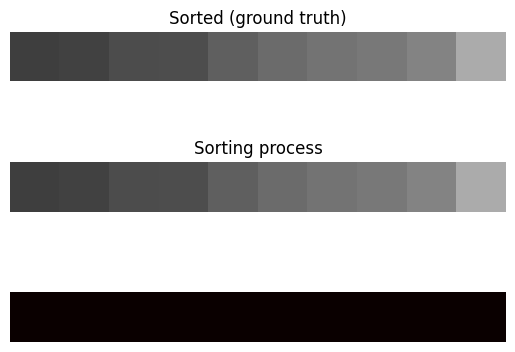

In [69]:
if args.eval_path is not None:
    runner.evaluate()
    wandb.finish()

#Conclusion (Summary)

In this notebook we looked over the Sorting problem via the lens of graphically structured diffusion models. If you re-check the plot for training (the video after the definition of the `plot` function), we can see as the steps increase, our approximated sorted vector will become close to the ground-truth sorted vector, thus less red blocks. In the evaluated checkpoint, we see no red blocks that means we do not have any mismatches.

References:

[1] https://github.com/plai-group/gsdm

[2] https://github.com/acids-ircam/diffusion_models/blob/main/diffusion_03_waveform.ipynb

[3] https://www.youtube.com/watch?v=TQZcT6-r68A​